In [2]:
%load_ext cuml.accel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import mixed_precision

hv.extension('bokeh')
# Use FP16 where possible for double throughput on Tensor Cores
mixed_precision.set_global_policy('mixed_float16')  # :contentReference[oaicite:4]{index=4}


cuML: Could not enable managed memory.
cuML: Installed accelerator for sklearn.
cuML: Successfully initialized accelerator.


2025-04-29 00:57:31.560554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745868451.634951     875 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745868451.657744     875 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745868451.919578     875 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745868451.919601     875 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745868451.919602     875 computation_placer.cc:177] computation placer alr

In [3]:

# -- Load and Clean ---------------------------------------------------------
data = pd.read_csv('combined_dataset.csv')
data.dropna(inplace=True)

data = data.drop(columns=['i_pol(t,T,A+DA)', 'Delta age (DA)']).drop_duplicates()

# … [your existing imports] …
TARGET      = 'I_pol(t,T,A)(uA)'
GROUP_COLS  = ['hour','Temprature']
LAGS        = [1,2,3,4,5]
WINDOWS     = [3,5,10]

# 1) Sort to ensure proper group ordering
data = data.sort_values(GROUP_COLS + ['Time'])

# 2) Create lag features, then backfill/forward-fill per group
for lag in LAGS:
    data[f'{TARGET}_lag{lag}'] = (
        data.groupby(GROUP_COLS)[TARGET]
            .shift(lag)
    )
# Impute those initial NaNs from the next real value
data = ( data
    .groupby(GROUP_COLS)
    .apply(lambda g: g.bfill().ffill())
    .reset_index(drop=True)
)

# 3) Create rolling features with min_periods=1
for w in WINDOWS:
    grp = data.groupby(GROUP_COLS)[TARGET]
    data[f'{TARGET}_roll_mean{w}'] = (
        grp.rolling(window=w, min_periods=1)
           .mean()
           .reset_index(level=[0,1], drop=True)
    )
    data[f'{TARGET}_roll_std{w}']  = (
        grp.rolling(window=w, min_periods=1)
           .std()
           .reset_index(level=[0,1], drop=True)
    )

# 4) (Optional) Add expanding-window mean as an extra feature
data[f'{TARGET}_expanding_mean'] = (
    data.groupby(GROUP_COLS)[TARGET]
        .expanding(min_periods=1)
        .mean()
        .shift(1)  # always look strictly at the past
        .reset_index(level=[0,1], drop=True)
)
data.dropna(inplace=True)
# -- Split Test Holdout -----------------------------------------------------
mask = (data['hour'] == 192) & (data['Temprature'] == 30)
X = data.drop(columns=['I_pol(t,T,A)(uA)'])
y = data['I_pol(t,T,A)(uA)']
X_train_base, y_train_base = X[~mask], y[~mask]
X_test, y_test         = X[mask], y[mask]

dpi = X_train_base.shape[1]   # number of features for LSTM


/tmp/ipykernel_875/3116486765.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.bfill().ffill())


In [8]:
display(data[data.isna().any(axis=1)])
print(data.describe().iloc[:,:8].round(2))


Empty DataFrame
Columns: [hour, Time, Temprature, %tanD, Resistivity, Permittivity, BDV, I_pol(t,T,A)(uA), I_pol(t,T,A)(uA)_lag1, I_pol(t,T,A)(uA)_lag2, I_pol(t,T,A)(uA)_lag3, I_pol(t,T,A)(uA)_lag4, I_pol(t,T,A)(uA)_lag5, I_pol(t,T,A)(uA)_roll_mean3, I_pol(t,T,A)(uA)_roll_std3, I_pol(t,T,A)(uA)_roll_mean5, I_pol(t,T,A)(uA)_roll_std5, I_pol(t,T,A)(uA)_roll_mean10, I_pol(t,T,A)(uA)_roll_std10, I_pol(t,T,A)(uA)_expanding_mean]
Index: []

           hour      Time  Temprature     %tanD   Resistivity  Permittivity  \
count  40318.00  40318.00    40318.00  40318.00  4.031800e+04      40318.00   
mean     193.20    235.90       70.47      0.10  1.153566e+14          2.06   
std      135.34    135.34       24.73      0.18  2.357511e+14          0.04   
min        0.00      1.00       30.00      0.00  2.964555e+12          1.96   
25%       96.00    119.00       50.00      0.02  1.559965e+13          2.02   
50%      192.00    236.00       70.00      0.05  3.573625e+13          2.06   
75%      288.00    353.00       90.00      0.09  8.265950e+13          2.09   
max      384.00    470.00      110.00      1.26  1.249215e+15          2.15   

            BDV  I_pol(t,T,A)(uA)  
count  40318.00          40318.00  
mean      31.91              0.15  
std        1.74              0.19  
min       29.00              0.00  
25%       31.00              0.03  
50%       32.50              0.09  
75%       33.00              0.20  



*** Using first 1 feature(s): ['%tanD'] ***

=== Training with 0% Augmentation ===
RandomForest: MAE=0.0007, RMSE=0.0007, R2=0.2676
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9976
KNN: MAE=0.0067, RMSE=0.0067, R2=-59.1280
Iteration 1, loss = 0.04607904Iteration 1, loss = 0.03736969

Iteration 1, loss = 0.05621681
Iteration 1, loss = 0.01137588
Iteration 1, loss = 0.01110863
Iteration 1, loss = 0.00749950
Iteration 2, loss = 0.01426755
Iteration 2, loss = 0.01247052
Iteration 2, loss = 0.01153455
Iteration 2, loss = 0.00488892
Iteration 2, loss = 0.00373912
Iteration 3, loss = 0.01175716
Iteration 3, loss = 0.00979139Iteration 2, loss = 0.00441041

Iteration 3, loss = 0.00990076
Iteration 4, loss = 0.01033835
Iteration 3, loss = 0.00344925
Iteration 4, loss = 0.00896700
Iteration 3, loss = 0.00262107
Iteration 4, loss = 0.00884647
Iteration 5, loss = 0.00944615
Iteration 3, loss = 0.00284795
Iteration 4, loss = 0.00262901
Iteration 5, loss = 0.00845325
Iteration 6, loss = 0.00884576
I

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 5% Augmentation ===
RandomForest: MAE=0.0002, RMSE=0.0003, R2=0.8935
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9989
KNN: MAE=0.0026, RMSE=0.0035, R2=-15.3418
Iteration 1, loss = 0.04679119Iteration 1, loss = 0.05844205

Iteration 1, loss = 0.07113473
Iteration 1, loss = 0.02128376
Iteration 1, loss = 0.04660446
Iteration 1, loss = 0.02906630
Iteration 2, loss = 0.00683889
Iteration 2, loss = 0.00299952
Iteration 2, loss = 0.00345918
Iteration 2, loss = 0.00152903
Iteration 2, loss = 0.00317845
Iteration 2, loss = 0.00482541
Iteration 3, loss = 0.00363708
Iteration 3, loss = 0.00226028
Iteration 3, loss = 0.00187425
Iteration 3, loss = 0.00073083
Iteration 4, loss = 0.00158914
Iteration 3, loss = 0.00290930
Iteration 4, loss = 0.00191436
Iteration 4, loss = 0.00227891
Iteration 3, loss = 0.00186928
Iteration 5, loss = 0.00142597
Iteration 5, loss = 0.00160155
Iteration 5, loss = 0.00167408
Iteration 4, loss = 0.00206578
Iteration 4, loss = 0.00054474
Iteration 6, lo

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 10% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9734
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9992
KNN: MAE=0.0002, RMSE=0.0006, R2=0.5807
Iteration 1, loss = 0.06488530
Iteration 1, loss = 0.07795573
Iteration 1, loss = 0.05316267
Iteration 1, loss = 0.01923938
Iteration 1, loss = 0.02285667
Iteration 1, loss = 0.01593121
Iteration 2, loss = 0.00982174
Iteration 2, loss = 0.01321986
Iteration 2, loss = 0.00936846
Iteration 2, loss = 0.00796334
Iteration 2, loss = 0.00807717
Iteration 3, loss = 0.00861662
Iteration 2, loss = 0.00803194
Iteration 3, loss = 0.00998834
Iteration 3, loss = 0.00821904
Iteration 4, loss = 0.00826772
Iteration 4, loss = 0.00863125
Iteration 4, loss = 0.00793357
Iteration 3, loss = 0.00783626
Iteration 3, loss = 0.00779358
Iteration 3, loss = 0.00782224
Iteration 5, loss = 0.00802544
Iteration 5, loss = 0.00795136
Iteration 5, loss = 0.00777088
Iteration 4, loss = 0.00769290
Iteration 4, loss = 0.00767240
Iteration 6, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 15% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9846
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9993
KNN: MAE=0.0000, RMSE=0.0000, R2=0.9987
Iteration 1, loss = 0.00072377
Iteration 1, loss = 0.00168231
Iteration 1, loss = 0.00149503
Iteration 1, loss = 0.05448437
Iteration 1, loss = 0.02921884
Iteration 1, loss = 0.03712650
Iteration 2, loss = 0.00005446
Iteration 2, loss = 0.00004137
Iteration 2, loss = 0.00003429
Iteration 3, loss = 0.00002836
Iteration 2, loss = 0.00943805
Iteration 2, loss = 0.01105797
Iteration 3, loss = 0.00002314
Iteration 3, loss = 0.00003302
Iteration 2, loss = 0.01268665
Iteration 4, loss = 0.00002424
Iteration 4, loss = 0.00001963
Iteration 4, loss = 0.00002649
Iteration 3, loss = 0.00977713
Iteration 3, loss = 0.00864605
Iteration 3, loss = 0.01080965
Iteration 5, loss = 0.00001784
Iteration 5, loss = 0.00002170
Iteration 5, loss = 0.00002323
Iteration 6, loss = 0.00001681
Iteration 6, loss = 0.00002048
Iteration 4, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 20% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9822
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9995
KNN: MAE=0.0000, RMSE=0.0000, R2=0.9992
Iteration 1, loss = 0.00153090
Iteration 1, loss = 0.00167815
Iteration 1, loss = 0.00077518
Iteration 1, loss = 0.00915023
Iteration 1, loss = 0.00806060
Iteration 1, loss = 0.00906189
Iteration 2, loss = 0.00594520
Iteration 2, loss = 0.00004397
Iteration 2, loss = 0.00003687
Iteration 2, loss = 0.00642611
Iteration 2, loss = 0.00005521
Iteration 2, loss = 0.00653568
Iteration 3, loss = 0.00002844
Iteration 3, loss = 0.00003346
Iteration 3, loss = 0.00515247
Iteration 3, loss = 0.00002590
Iteration 3, loss = 0.00571439
Iteration 3, loss = 0.00582898
Iteration 4, loss = 0.00002406
Iteration 4, loss = 0.00508458Iteration 4, loss = 0.00002787

Iteration 4, loss = 0.00002070
Iteration 4, loss = 0.00446460
Iteration 4, loss = 0.00518954
Iteration 5, loss = 0.00001870
Iteration 5, loss = 0.00002195
Iteration 5, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)

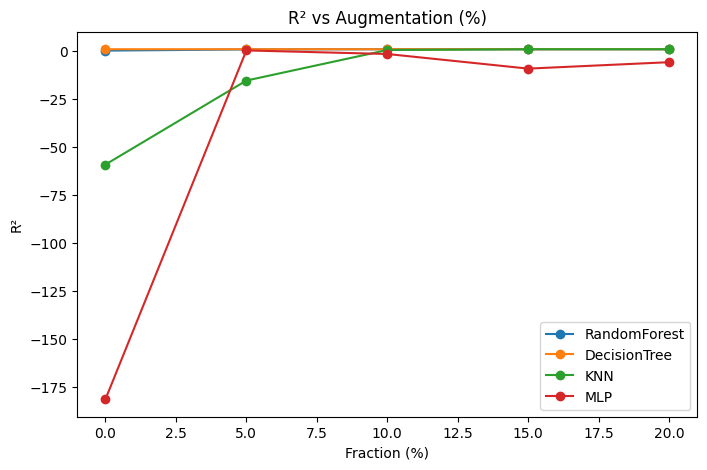

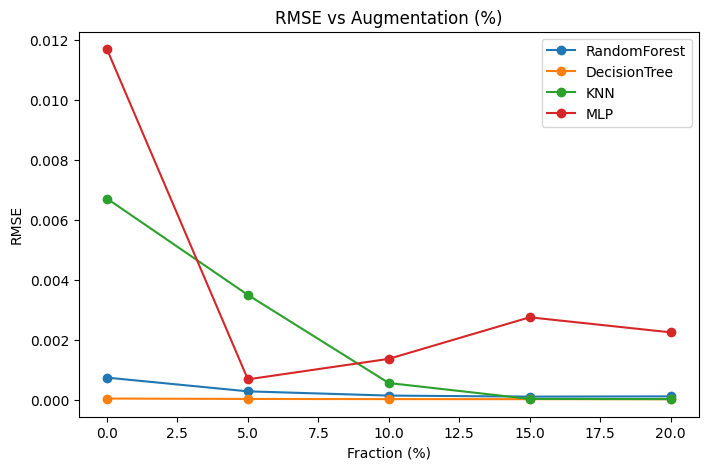

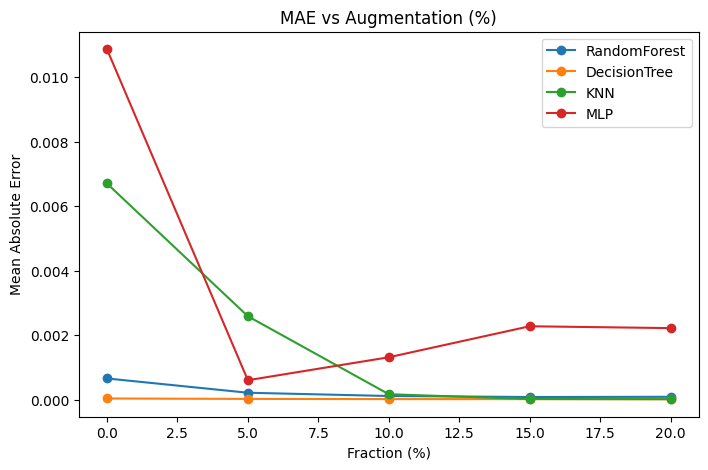


*** Using first 2 feature(s): ['%tanD', 'Resistivity'] ***

=== Training with 0% Augmentation ===
RandomForest: MAE=0.0006, RMSE=0.0007, R2=0.2831
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9976
KNN: MAE=0.0067, RMSE=0.0067, R2=-59.1280
Iteration 1, loss = 0.02289431
Iteration 1, loss = 0.02893975
Iteration 1, loss = 0.01293937
Iteration 1, loss = 0.05449453
Iteration 1, loss = 0.03693500Iteration 1, loss = 0.02929629

Iteration 2, loss = 0.00056121
Iteration 2, loss = 0.00052407
Iteration 2, loss = 0.00020062
Iteration 2, loss = 0.01110878
Iteration 2, loss = 0.01276001
Iteration 2, loss = 0.00947107
Iteration 3, loss = 0.00024026
Iteration 3, loss = 0.00022164
Iteration 3, loss = 0.00009529
Iteration 3, loss = 0.00980755
Iteration 4, loss = 0.00013866
Iteration 3, loss = 0.01085083
Iteration 4, loss = 0.00014554
Iteration 4, loss = 0.00006676
Iteration 3, loss = 0.00866476
Iteration 5, loss = 0.00009379
Iteration 5, loss = 0.00011255
Iteration 5, loss = 0.00005028
Iteration 4, loss

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 5% Augmentation ===
RandomForest: MAE=0.0002, RMSE=0.0003, R2=0.9117
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9989
KNN: MAE=0.0026, RMSE=0.0035, R2=-15.3418
Iteration 1, loss = 0.02349139
Iteration 1, loss = 0.02983539
Iteration 1, loss = 0.01301582
Iteration 1, loss = 0.02349139
Iteration 1, loss = 0.01301582
Iteration 1, loss = 0.02983539
Iteration 2, loss = 0.00019526
Iteration 2, loss = 0.00053113
Iteration 2, loss = 0.00056380
Iteration 2, loss = 0.00056380
Iteration 2, loss = 0.00053113
Iteration 2, loss = 0.00019526
Iteration 3, loss = 0.00022855
Iteration 3, loss = 0.00009470
Iteration 3, loss = 0.00024513
Iteration 3, loss = 0.00024513
Iteration 3, loss = 0.00022855
Iteration 3, loss = 0.00009470
Iteration 4, loss = 0.00014834
Iteration 4, loss = 0.00014012
Iteration 4, loss = 0.00006628
Iteration 4, loss = 0.00014012
Iteration 4, loss = 0.00006628
Iteration 4, loss = 0.00014834
Iteration 5, loss = 0.00011345
Iteration 5, loss = 0.00009361
Iteration 5, lo

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 10% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9723
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9992
KNN: MAE=0.0002, RMSE=0.0006, R2=0.5807
Iteration 1, loss = 0.03725158
Iteration 1, loss = 0.05610947
Iteration 1, loss = 0.04588259
Iteration 2, loss = 0.01426083
Iteration 2, loss = 0.01247285
Iteration 2, loss = 0.01155103
Iteration 1, loss = 0.04669663
Iteration 1, loss = 0.02921353
Iteration 1, loss = 0.02125805
Iteration 3, loss = 0.01174471
Iteration 3, loss = 0.00989958
Iteration 3, loss = 0.00979262
Iteration 4, loss = 0.01033262
Iteration 4, loss = 0.00884357
Iteration 4, loss = 0.00896763
Iteration 2, loss = 0.00152689
Iteration 2, loss = 0.00314465
Iteration 5, loss = 0.00827451
Iteration 5, loss = 0.00944123
Iteration 2, loss = 0.00479635
Iteration 5, loss = 0.00845291
Iteration 6, loss = 0.00884197
Iteration 6, loss = 0.00809643
Iteration 6, loss = 0.00792131
Iteration 7, loss = 0.00783425
Iteration 7, loss = 0.00841620
Iteration 3, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 15% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9818
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9993
KNN: MAE=0.0000, RMSE=0.0000, R2=0.9987
Iteration 1, loss = 0.03945397
Iteration 1, loss = 0.03093119
Iteration 1, loss = 0.04965338
Iteration 1, loss = 0.02741518
Iteration 1, loss = 0.03486848
Iteration 1, loss = 0.02014009
Iteration 2, loss = 0.00518978
Iteration 2, loss = 0.00786510
Iteration 2, loss = 0.00610293
Iteration 3, loss = 0.00343015
Iteration 3, loss = 0.00538336
Iteration 2, loss = 0.00685468
Iteration 3, loss = 0.00354530
Iteration 2, loss = 0.00682312
Iteration 2, loss = 0.00649257
Iteration 4, loss = 0.00397096Iteration 4, loss = 0.00248798

Iteration 4, loss = 0.00260545
Iteration 3, loss = 0.00648518
Iteration 3, loss = 0.00646443
Iteration 5, loss = 0.00308271
Iteration 5, loss = 0.00191980
Iteration 5, loss = 0.00209335
Iteration 3, loss = 0.00630892
Iteration 6, loss = 0.00248553
Iteration 6, loss = 0.00156643
Iteration 4, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 20% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9857
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9995
KNN: MAE=0.0000, RMSE=0.0000, R2=0.9992
Iteration 1, loss = 0.01017352
Iteration 1, loss = 0.00842722
Iteration 1, loss = 0.02308994
Iteration 1, loss = 0.01503926
Iteration 1, loss = 0.01821946
Iteration 1, loss = 0.01646471
Iteration 2, loss = 0.00020389
Iteration 2, loss = 0.00806694
Iteration 2, loss = 0.00801430
Iteration 2, loss = 0.00019702
Iteration 2, loss = 0.00803533
Iteration 2, loss = 0.00013946
Iteration 3, loss = 0.00771937
Iteration 3, loss = 0.00772075
Iteration 3, loss = 0.00006211
Iteration 3, loss = 0.00010388
Iteration 3, loss = 0.00764579
Iteration 3, loss = 0.00010090
Iteration 4, loss = 0.00008168
Iteration 4, loss = 0.00004954Iteration 4, loss = 0.00741919

Iteration 4, loss = 0.00746608
Iteration 4, loss = 0.00731284
Iteration 4, loss = 0.00007024
Iteration 5, loss = 0.00004237
Iteration 5, loss = 0.00712005
Iteration 5, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)

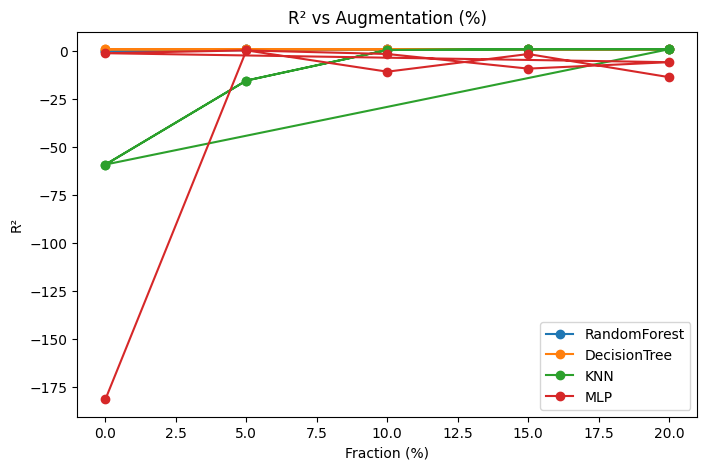

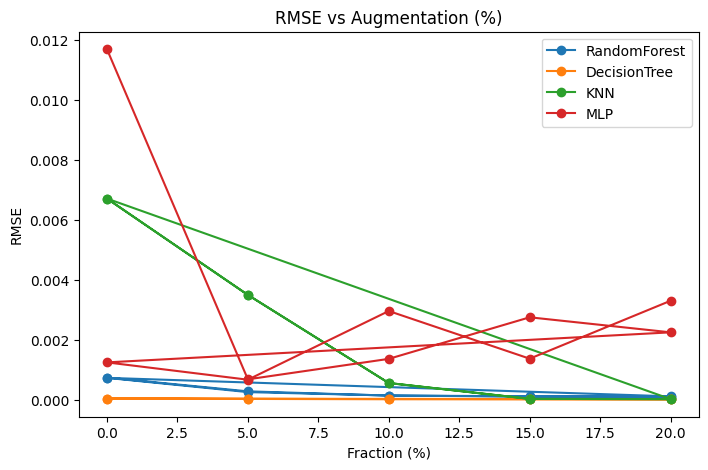

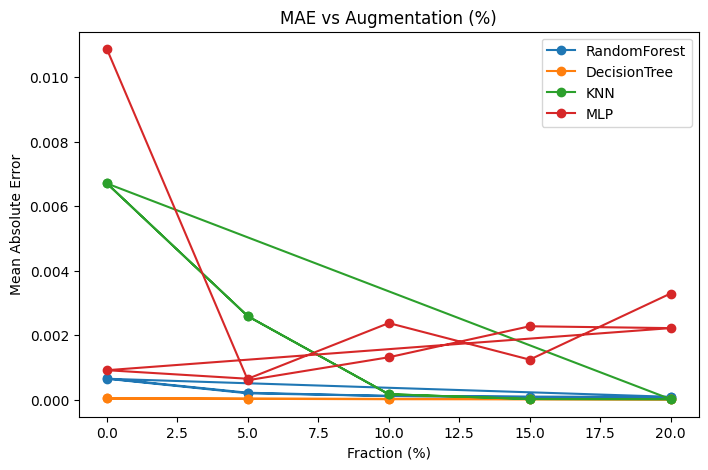


*** Using first 3 feature(s): ['%tanD', 'Resistivity', 'Permittivity'] ***

=== Training with 0% Augmentation ===
RandomForest: MAE=0.0006, RMSE=0.0007, R2=0.3426
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9976
KNN: MAE=0.0067, RMSE=0.0067, R2=-59.1280
Iteration 1, loss = 0.02289431
Iteration 1, loss = 0.02893975
Iteration 1, loss = 0.01293937
Iteration 1, loss = 0.05449453
Iteration 1, loss = 0.03693500
Iteration 1, loss = 0.02929629
Iteration 2, loss = 0.00056121
Iteration 2, loss = 0.00052407
Iteration 2, loss = 0.00020062
Iteration 2, loss = 0.01110878
Iteration 3, loss = 0.00024026
Iteration 2, loss = 0.00947107
Iteration 2, loss = 0.01276001
Iteration 3, loss = 0.00022164
Iteration 3, loss = 0.00009529
Iteration 4, loss = 0.00013866
Iteration 4, loss = 0.00006676
Iteration 4, loss = 0.00014554
Iteration 3, loss = 0.00866476
Iteration 3, loss = 0.00980755
Iteration 3, loss = 0.01085083
Iteration 5, loss = 0.00009379
Iteration 5, loss = 0.00005028
Iteration 5, loss = 0.00011255
I

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 5% Augmentation ===
RandomForest: MAE=0.0002, RMSE=0.0003, R2=0.9039
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9989
KNN: MAE=0.0026, RMSE=0.0035, R2=-15.3418
Iteration 1, loss = 0.01110581
Iteration 1, loss = 0.00749452
Iteration 1, loss = 0.01137100
Iteration 1, loss = 0.02906630
Iteration 1, loss = 0.02128376
Iteration 1, loss = 0.04660446
Iteration 2, loss = 0.00489795
Iteration 2, loss = 0.00373788
Iteration 2, loss = 0.00441587
Iteration 3, loss = 0.00345311
Iteration 2, loss = 0.00482541
Iteration 3, loss = 0.00261943
Iteration 3, loss = 0.00285457
Iteration 2, loss = 0.00317845
Iteration 2, loss = 0.00152903
Iteration 4, loss = 0.00214869
Iteration 4, loss = 0.00262936
Iteration 4, loss = 0.00202427
Iteration 3, loss = 0.00290930
Iteration 3, loss = 0.00186928
Iteration 3, loss = 0.00073083
Iteration 5, loss = 0.00173717
Iteration 5, loss = 0.00207499
Iteration 5, loss = 0.00162881
Iteration 6, loss = 0.00146362
Iteration 4, loss = 0.00206578
Iteration 4, lo

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 10% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9731
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9992
KNN: MAE=0.0002, RMSE=0.0006, R2=0.5807
Iteration 1, loss = 0.01197814
Iteration 1, loss = 0.03725158
Iteration 1, loss = 0.02110300
Iteration 1, loss = 0.05610947
Iteration 1, loss = 0.02117778
Iteration 1, loss = 0.04588259
Iteration 2, loss = 0.01426083
Iteration 2, loss = 0.01247285
Iteration 2, loss = 0.00563686
Iteration 2, loss = 0.00559743
Iteration 2, loss = 0.00583978
Iteration 2, loss = 0.01155103
Iteration 3, loss = 0.01174471
Iteration 3, loss = 0.00989958
Iteration 3, loss = 0.00503090
Iteration 3, loss = 0.00514839
Iteration 3, loss = 0.00979262Iteration 3, loss = 0.00538579

Iteration 4, loss = 0.00884357
Iteration 4, loss = 0.01033262
Iteration 4, loss = 0.00469608
Iteration 4, loss = 0.00479107
Iteration 4, loss = 0.00896763
Iteration 4, loss = 0.00509530
Iteration 5, loss = 0.00944123
Iteration 5, loss = 0.00827451
Iteration 5, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 15% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9814
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9993
KNN: MAE=0.0000, RMSE=0.0000, R2=0.9987
Iteration 1, loss = 0.03093119
Iteration 1, loss = 0.04965338
Iteration 1, loss = 0.03945397
Iteration 1, loss = 0.02741518
Iteration 1, loss = 0.03486848
Iteration 1, loss = 0.02014009
Iteration 2, loss = 0.00610293
Iteration 2, loss = 0.00786510
Iteration 2, loss = 0.00518978
Iteration 3, loss = 0.00354530
Iteration 3, loss = 0.00343015
Iteration 3, loss = 0.00538336
Iteration 2, loss = 0.00682312
Iteration 2, loss = 0.00685468
Iteration 2, loss = 0.00649257
Iteration 4, loss = 0.00260545
Iteration 4, loss = 0.00248798
Iteration 4, loss = 0.00397096
Iteration 3, loss = 0.00648518
Iteration 3, loss = 0.00646443
Iteration 5, loss = 0.00191980
Iteration 3, loss = 0.00630892
Iteration 5, loss = 0.00209335
Iteration 5, loss = 0.00308271
Iteration 6, loss = 0.00173800
Iteration 6, loss = 0.00248553
Iteration 6, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 20% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9820
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9995
KNN: MAE=0.0000, RMSE=0.0000, R2=0.9992
Iteration 1, loss = 0.05443086
Iteration 1, loss = 0.01503926
Iteration 1, loss = 0.00842722
Iteration 1, loss = 0.03727742
Iteration 1, loss = 0.02928899
Iteration 1, loss = 0.01017352
Iteration 2, loss = 0.01116855
Iteration 2, loss = 0.00013946
Iteration 2, loss = 0.00955277
Iteration 2, loss = 0.01272336
Iteration 2, loss = 0.00019702
Iteration 2, loss = 0.00020389
Iteration 3, loss = 0.00006211
Iteration 3, loss = 0.00990032
Iteration 3, loss = 0.00010090
Iteration 3, loss = 0.01089091
Iteration 3, loss = 0.00010388
Iteration 3, loss = 0.00878563
Iteration 4, loss = 0.00945271
Iteration 4, loss = 0.00008168
Iteration 4, loss = 0.00007024
Iteration 4, loss = 0.01007703Iteration 4, loss = 0.00859976

Iteration 4, loss = 0.00004954
Iteration 5, loss = 0.00922467
Iteration 5, loss = 0.00004237
Iteration 5, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)

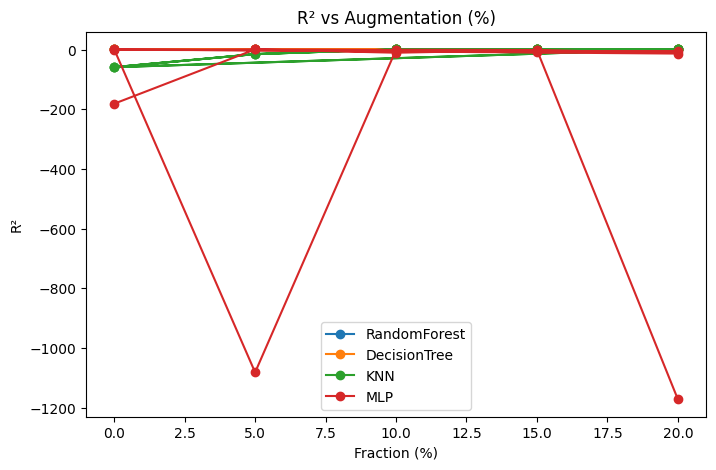

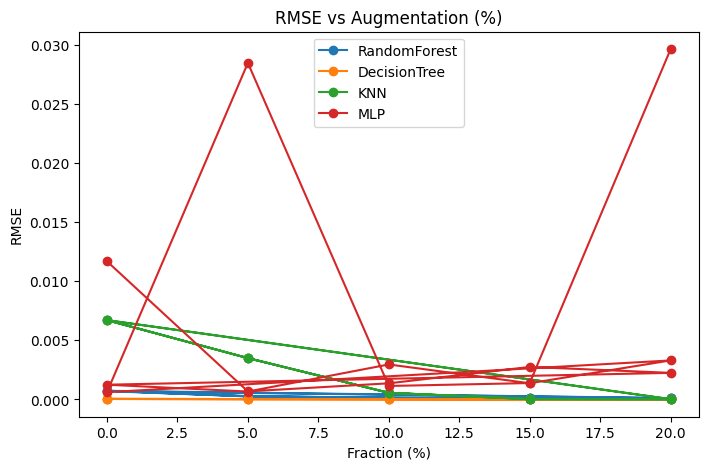

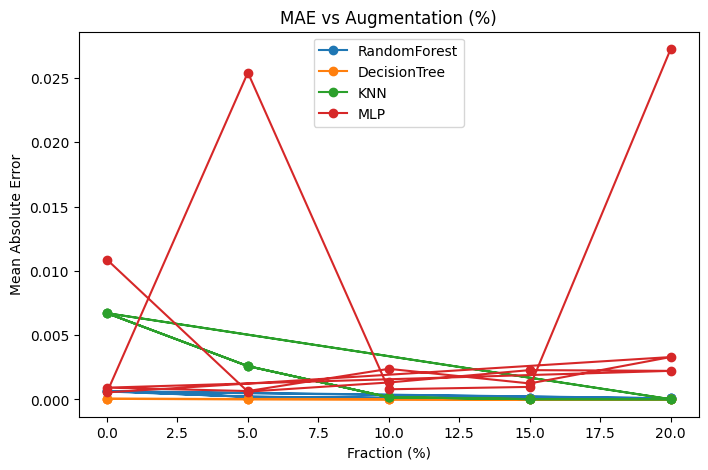


*** Using first 4 feature(s): ['%tanD', 'Resistivity', 'Permittivity', 'BDV'] ***

=== Training with 0% Augmentation ===
RandomForest: MAE=0.0007, RMSE=0.0008, R2=0.2287
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9976
KNN: MAE=0.0067, RMSE=0.0067, R2=-59.1280
Iteration 1, loss = 0.00151484
Iteration 1, loss = 0.00141139
Iteration 1, loss = 0.00072835
Iteration 1, loss = 0.02899916
Iteration 1, loss = 0.02136168
Iteration 1, loss = 0.04656016
Iteration 2, loss = 0.00004945
Iteration 2, loss = 0.00003493
Iteration 2, loss = 0.00004128
Iteration 2, loss = 0.00482632
Iteration 2, loss = 0.00153749
Iteration 2, loss = 0.00317626
Iteration 3, loss = 0.00003217
Iteration 3, loss = 0.00002319
Iteration 3, loss = 0.00002740
Iteration 4, loss = 0.00001953
Iteration 4, loss = 0.00002677
Iteration 4, loss = 0.00002400
Iteration 3, loss = 0.00291846
Iteration 3, loss = 0.00073203
Iteration 3, loss = 0.00187632
Iteration 5, loss = 0.00001774
Iteration 5, loss = 0.00002383
Iteration 5, loss = 0.000

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 5% Augmentation ===
RandomForest: MAE=0.0002, RMSE=0.0003, R2=0.9100
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9989
KNN: MAE=0.0026, RMSE=0.0035, R2=-15.3418
Iteration 1, loss = 0.03731741
Iteration 1, loss = 0.04588642
Iteration 1, loss = 0.05615470
Iteration 1, loss = 0.01930217
Iteration 1, loss = 0.01542473
Iteration 1, loss = 0.01903750
Iteration 2, loss = 0.01426576
Iteration 2, loss = 0.01249064
Iteration 2, loss = 0.01154652
Iteration 2, loss = 0.01234551
Iteration 2, loss = 0.01166636
Iteration 2, loss = 0.01282778
Iteration 3, loss = 0.01175267
Iteration 3, loss = 0.00991194
Iteration 3, loss = 0.00979262
Iteration 4, loss = 0.01033486
Iteration 3, loss = 0.01078290
Iteration 3, loss = 0.01054658
Iteration 3, loss = 0.01138150
Iteration 4, loss = 0.00884904
Iteration 4, loss = 0.00896560
Iteration 5, loss = 0.00944436
Iteration 5, loss = 0.00827982
Iteration 4, loss = 0.01007577
Iteration 5, loss = 0.00845312
Iteration 4, loss = 0.00995033
Iteration 4, lo

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 10% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9720
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9992
KNN: MAE=0.0002, RMSE=0.0006, R2=0.5807
Iteration 1, loss = 0.03088202
Iteration 1, loss = 0.04974372Iteration 1, loss = 0.03951734

Iteration 1, loss = 0.01243402
Iteration 1, loss = 0.02925413
Iteration 1, loss = 0.02278815
Iteration 2, loss = 0.00789717
Iteration 2, loss = 0.00519119
Iteration 2, loss = 0.00611308
Iteration 3, loss = 0.00538390
Iteration 3, loss = 0.00354157
Iteration 3, loss = 0.00343460
Iteration 2, loss = 0.00019031
Iteration 2, loss = 0.00055880
Iteration 2, loss = 0.00056715
Iteration 4, loss = 0.00397365
Iteration 4, loss = 0.00248689
Iteration 4, loss = 0.00261091
Iteration 3, loss = 0.00009176
Iteration 5, loss = 0.00209735
Iteration 5, loss = 0.00308387
Iteration 3, loss = 0.00023674
Iteration 5, loss = 0.00191902
Iteration 3, loss = 0.00024216
Iteration 6, loss = 0.00248600
Iteration 6, loss = 0.00174190
Iteration 6, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 15% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9804
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9993
KNN: MAE=0.0000, RMSE=0.0000, R2=0.9987
Iteration 1, loss = 0.06473195
Iteration 1, loss = 0.01925068
Iteration 1, loss = 0.07800598
Iteration 1, loss = 0.05316823
Iteration 1, loss = 0.01896396
Iteration 1, loss = 0.01541122
Iteration 2, loss = 0.01235295
Iteration 2, loss = 0.01283629
Iteration 2, loss = 0.00934709
Iteration 2, loss = 0.00981648
Iteration 2, loss = 0.01165192
Iteration 2, loss = 0.01318340
Iteration 3, loss = 0.01078324
Iteration 3, loss = 0.01138083
Iteration 3, loss = 0.00861088
Iteration 3, loss = 0.01053497
Iteration 3, loss = 0.00822354
Iteration 3, loss = 0.00996210
Iteration 4, loss = 0.01055060
Iteration 4, loss = 0.01007187
Iteration 4, loss = 0.00826150Iteration 4, loss = 0.00994003

Iteration 4, loss = 0.00793651
Iteration 4, loss = 0.00861121
Iteration 5, loss = 0.00999033
Iteration 5, loss = 0.00965643
Iteration 5, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)


=== Training with 20% Augmentation ===
RandomForest: MAE=0.0001, RMSE=0.0001, R2=0.9828
DecisionTree: MAE=0.0000, RMSE=0.0000, R2=0.9995
KNN: MAE=0.0000, RMSE=0.0000, R2=0.9992
Iteration 1, loss = 0.00906189
Iteration 1, loss = 0.00915023
Iteration 1, loss = 0.00806060
Iteration 1, loss = 0.04636307
Iteration 1, loss = 0.02920787
Iteration 1, loss = 0.02122093
Iteration 2, loss = 0.00642611
Iteration 2, loss = 0.00653568
Iteration 2, loss = 0.00594520
Iteration 2, loss = 0.00310451
Iteration 3, loss = 0.00571439
Iteration 2, loss = 0.00465879
Iteration 3, loss = 0.00515247
Iteration 2, loss = 0.00148690
Iteration 3, loss = 0.00582898
Iteration 4, loss = 0.00508458
Iteration 4, loss = 0.00446460
Iteration 4, loss = 0.00518954
Iteration 3, loss = 0.00183955
Iteration 3, loss = 0.00282993
Iteration 3, loss = 0.00072241
Iteration 5, loss = 0.00451745
Iteration 5, loss = 0.00386321
Iteration 5, loss = 0.00461052
Iteration 4, loss = 0.00201944
Iteration 6, loss = 0.00333756
Iteration 4, los

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Scatter   [Time]   (value)
   .NdOverlay.IV  :NdOverlay   [Variable]
      :Scatter   [Time]   (value)

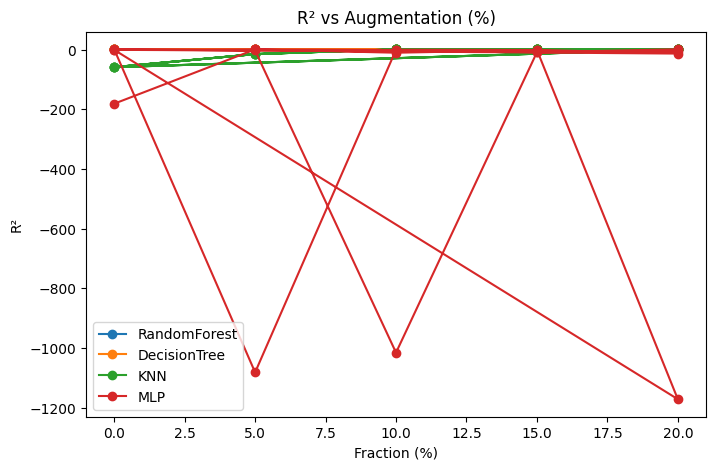

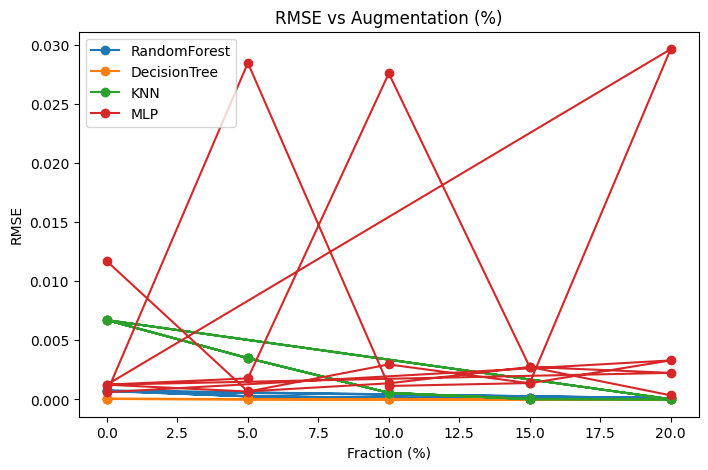

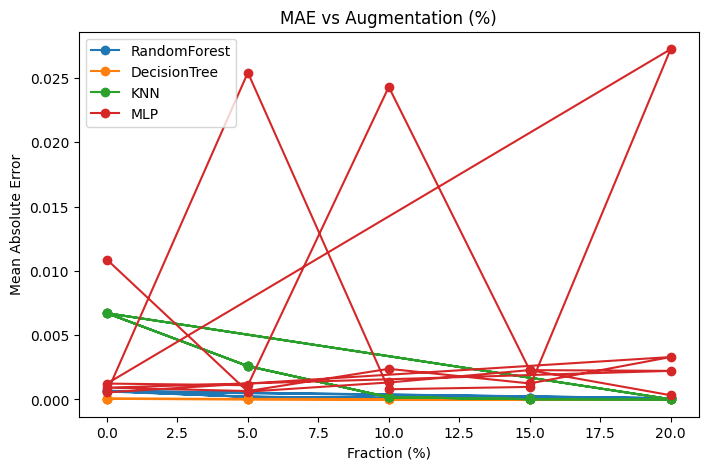

In [9]:
batch_size = 512  # increase batch size for better GPU utilization :contentReference[oaicite:5]{index=5}

def make_dataset(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    return (ds.shuffle(10000)
              .batch(batch_size)
              .prefetch(tf.data.AUTOTUNE))  # :contentReference[oaicite:6]{index=6}
scaler = StandardScaler()

# -- Model Definitions ------------------------------------------------------
def create_lstm_model(input_dim, look_back=5):
    model = Sequential([
        LSTM(32, input_shape=(look_back, input_dim)),  # :contentReference[oaicite:7]{index=7}
        Dense(1, dtype='float32')  # output in FP32 for stability
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


# SVR hyperparameter tuning
svr_param_grid = {
    'kernel': ['rbf', 'poly'],
    'C':      [0.1, 1, 10],
    'epsilon':[0.01, 0.1, 1]
}
tuned_svr = SVR()
svr_cv = GridSearchCV(tuned_svr, svr_param_grid, cv=3, n_jobs=-1)

# MLP hyperparameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
tuned_mlp = MLPRegressor(random_state=42, max_iter=1000,verbose=1,batch_size=512)
mlp_cv = RandomizedSearchCV(tuned_mlp, mlp_param_grid, cv=3,n_iter=5,  n_jobs=-1)

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'KNN':          KNeighborsRegressor(n_neighbors=3),
    # 'SVR':          svr_cv,
    'MLP':          mlp_cv,
    # 'LSTM':         KerasRegressor(model=lambda: create_lstm_model(dpi),
    #                                epochs=50, batch_size=batch_size, verbose=0)
}
features = ['%tanD', 'Resistivity', 'Permittivity', 'BDV']
fractions = [0, 0.05, 0.10, 0.15, 0.20]
# fractions = [0.20]
all_evals = []

for n_feats in range(1, len(features) + 1):
    # selected_feats = features
    selected_feats = features[:n_feats]
    print(f"\n*** Using first {n_feats} feature(s): {selected_feats} ***")
    for frac in fractions:
        print(f"\n=== Training with {int(frac*100)}% Augmentation ===")
        # Build train fold
        if frac > 0:
            X_train = pd.concat([
                X_train_base,
                X_test.sample(frac=frac, random_state=42)
            ])
            y_train = pd.concat([
                y_train_base,
                y_test.sample(frac=frac, random_state=42)
            ])
        else:
            X_train, y_train = X_train_base.copy(), y_train_base.copy()

        # Scale data
        X_tr_s = scaler.fit_transform(X_train)
        X_te_s = scaler.transform(X_test)

        preds = {}
        for name, model in models.items():
            needs_scale = name in ['KNN', 'SVR', 'MLP']
            X_tr = X_tr_s if needs_scale else X_train.values
            X_te = X_te_s if needs_scale else X_test.values

            if name == 'LSTM':
                look_back = 5
                train_gen = TimeseriesGenerator(X_tr_s, y_train.values,
                                                length=look_back, batch_size=batch_size)
                test_gen  = TimeseriesGenerator(X_te_s, y_test.values,
                                                length=look_back, batch_size=len(X_te_s))

                # rebuild & train a fresh LSTM
                lstm = create_lstm_model(input_dim=dpi, look_back=look_back)
                lstm.fit(train_gen, epochs=50, verbose=1)
                print("LSTM training done")
                # predict
                y_pred = lstm.predict(test_gen).ravel()
                print("LSTM prediction done")

                results = lstm.evaluate(
                                    test_gen,
                                    verbose=1        # shows a progress bar per epoch :contentReference[oaicite:1]{index=1}
                                    )

                display(results)
            else:
                # Fit & tune
                model.fit(X_tr, y_train.values)
                if name in ['SVR', 'MLP']:
                    print(f"{name} best params:", model.best_params_)

                # Predict
                y_pred = model.predict(X_te)
                preds[name] = y_pred

                # Evaluate
                mae  = mean_absolute_error(y_test, y_pred)
                mse  = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                r2   = r2_score(y_test, y_pred)
            print(f"{name}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
            all_evals.append({
                'features': selected_feats,
                'fraction': frac,
                'model':    name,
                'MAE':      mae,
                'RMSE':     rmse,
                'R2':       r2,
            })

        # -- Plot per-model predictions vs true in 2-column layout ----------
        df_res = X_test.copy()
        df_res['True'] = y_test.values
        for n, y_p in preds.items():
            df_res[f'{n}_Pred'] = y_p

        plot_list = []
        for model_name in preds:
            p = df_res.hvplot.scatter(
                x='Time',
                y=['True', f'{model_name}_Pred'],
                title=f"{model_name} Predictions @ {int(frac*100)}% Augmentation with selected feats: {selected_feats}",
                xlabel='Time',
                ylabel='I_pol (uA)'
            )
            plot_list.append(p)

        layout = hv.Layout(plot_list).cols(2)
        hv.output(layout)

    # -- Summary plots ----------------------------------------------------------
    df_eval = pd.DataFrame(all_evals)

    plt.figure(figsize=(8,5))
    for m in df_eval.model.unique():
        sub = df_eval[df_eval.model == m]
        plt.plot(sub.fraction*100, sub.R2, marker='o', label=m)
    plt.title('R² vs Augmentation (%)')
    plt.xlabel('Fraction (%)')
    plt.ylabel('R²')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    for m in df_eval.model.unique():
        sub = df_eval[df_eval.model == m]
        plt.plot(sub.fraction*100, sub.RMSE, marker='o', label=m)
    plt.title('RMSE vs Augmentation (%)')
    plt.xlabel('Fraction (%)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    for m in df_eval.model.unique():
        sub = df_eval[df_eval.model == m]
        plt.plot(sub.fraction*100, sub.MAE, marker='o', label=m)
    plt.title('MAE vs Augmentation (%)')
    plt.xlabel('Fraction (%)')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()


In [7]:
display(pd.DataFrame(all_evals))

features  fraction         model       MAE  \
0                                   [%tanD]      0.00  RandomForest  0.000651   
1                                   [%tanD]      0.00  DecisionTree  0.000036   
2                                   [%tanD]      0.00           KNN  0.006705   
3                                   [%tanD]      0.00           MLP  0.010870   
4                                   [%tanD]      0.05  RandomForest  0.000190   
..                                      ...       ...           ...       ...   
75  [%tanD, Resistivity, Permittivity, BDV]      0.15           MLP  0.000972   
76  [%tanD, Resistivity, Permittivity, BDV]      0.20  RandomForest  0.000090   
77  [%tanD, Resistivity, Permittivity, BDV]      0.20  DecisionTree  0.000014   
78  [%tanD, Resistivity, Permittivity, BDV]      0.20           KNN  0.000015   
79  [%tanD, Resistivity, Permittivity, BDV]      0.20           MLP  0.002219   

        RMSE          R2  
0   0.000738    0.273709  
1   0.000042    0.997595  
2   0.006710  -59.128000  
3   0.011691 -181.494515  
4   0.000254    0.913834  
..       ...         ...  
75  0.001389   -1.574848  
76  0.000114    0.982711  
77  0.000020    0.999463  
78  0.000024    0.999244  
79  0.002250   -5.760414  

[80 rows x 6 columns]

/tmp/ipykernel_899/2516666106.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=['fraction','features'],inplace=True)


model       MAE      RMSE         R2
60  RandomForest  0.000656  0.000747   0.254507
61  DecisionTree  0.000036  0.000042   0.997595
62           KNN  0.006705  0.006710 -59.128000
63           MLP  0.002103  0.002105  -4.914925

,model,MAE,RMSE,R2
60,RandomForest,0.0006555801470277668,0.0007471948751273936,0.2545065018335405
61,DecisionTree,3.6347321934557804e-05,4.243979506557917e-05,0.9975949580978319
62,KNN,0.006705268487759801,0.006710429741194263,-59.12799999248645
63,MLP,0.002102822775748556,0.0021046824935268475,-4.914925357268105



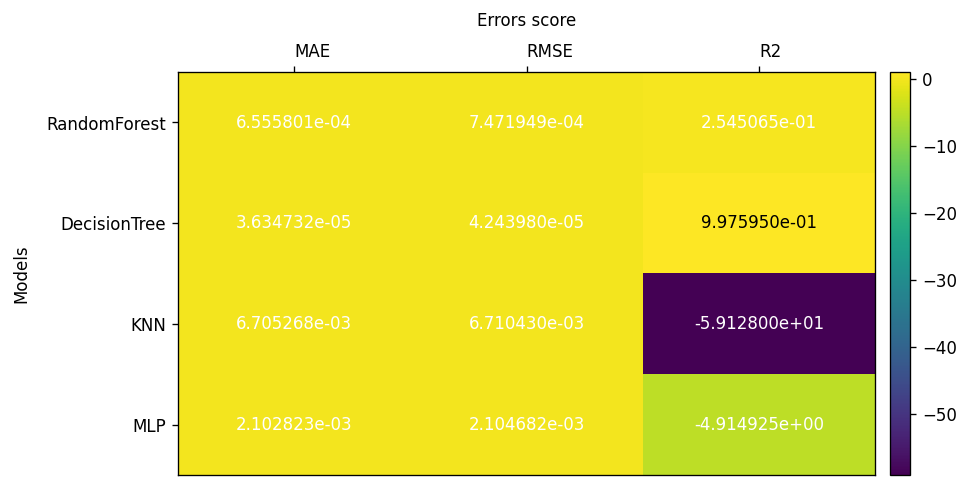

In [66]:
result_df = pd.DataFrame(all_evals)
result_df.dtypes
target_set = set(['%tanD', 'Resistivity', 'Permittivity', 'BDV'])

filtered_df = result_df[(result_df['features'].apply(lambda x: set(x) == target_set)) & (result_df["fraction"]==0)]
filtered_df.drop(columns=['fraction','features'],inplace=True)
display(filtered_df)
print(filtered_df.to_csv())

data = filtered_df.drop(columns='model').values
models = filtered_df['model'].tolist()
errors = ['MAE','RMSE','R2']

fig, ax = plt.subplots(
    figsize=(8, 4),        # smaller overall figure shrinks each cell
    dpi=120                # higher DPI for crisper text/lines
)

# Draw the heatmap
cax = ax.imshow(data, cmap='viridis', aspect='auto', interpolation='nearest')
fig.colorbar(cax, fraction=0.046, pad=0.02)

# X-axis (models) on top, angled
ax.set_xticks(np.arange(len(errors)))
ax.set_xticklabels(errors, rotation=0, ha='left')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel('Errors score', labelpad=10)

# Y-axis (feature combos) on left
ax.set_yticks(np.arange(len(models)))
ax.set_yticklabels(models, rotation=0)
ax.set_ylabel('Models', labelpad=10)

# ax.set_title('R² Heatmap', pad=12)

# Annotate each cell
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, f'{data[i,j]:e}',
                ha='center', va='center',
                color='white' if data[i,j] < data.max()/2 else 'black',
                fontsize=10)

plt.tight_layout(pad=0.5)
plt.show()


In [102]:
df_augmentation_plot = result_df[(result_df['features'].apply(lambda x: set(x) == target_set))]
# display(df_augmentation_plot.sort_values(by="fraction"))
for error in ["MAE","RMSE","R2"]:
    pvt = df_augmentation_plot.pivot_table(index='model', columns='fraction', values=error, aggfunc='mean')
    pvt.columns = [f"{col}%" for col in pvt.columns]
    pvt = pvt.map(lambda x: f"{x:.5e}")
    display(pvt)
    print(error)
    print(pvt.to_csv())

# plt.figure(figsize=(8,5))
# for m in df_augmentation_plot.model.unique():
#     sub = df_augmentation_plot[(df_augmentation_plot.model == m) ]
#     plt.plot(sub.fraction*100, sub.R2, marker='o', label=m)
# plt.title('R² vs Progressive Data Exposure')
# plt.xlabel('Fraction (%)')
# plt.ylabel('R²')
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,5))
# for m in df_augmentation_plot.model.unique():
#     sub = df_augmentation_plot[df_augmentation_plot.model == m]
#     plt.plot(sub.fraction*100, sub.RMSE, marker='o', label=m)
# plt.title('RMSE vs Progressive Data Exposure)')
# plt.xlabel('Fraction (%)')
# plt.ylabel('RMSE')
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,5))
# for m in df_augmentation_plot.model.unique():
#     sub = df_augmentation_plot[df_augmentation_plot.model == m]
#     plt.plot(sub.fraction*100, sub.MAE, marker='o', label=m)
# plt.title('MAE vs Progressive Data Exposure')
# plt.xlabel('Fraction (%)')
# plt.ylabel('Mean Absolute Error')
# plt.legend()
# plt.show()

0.0%        0.05%         0.1%        0.15%         0.2%
model                                                                        
DecisionTree  3.63473e-05  2.33518e-05  1.78381e-05  1.62262e-05  1.36015e-05
KNN           6.70527e-03  2.58778e-03  1.68758e-04  1.99452e-05  1.50611e-05
MLP           2.10282e-03  1.37305e-03  5.56965e-04  9.71702e-04  2.21936e-03
RandomForest  6.55580e-04  1.91696e-04  9.25903e-05  1.10971e-04  9.02078e-05

MAE
model,0.0%,0.05%,0.1%,0.15%,0.2%
DecisionTree,3.63473e-05,2.33518e-05,1.78381e-05,1.62262e-05,1.36015e-05
KNN,6.70527e-03,2.58778e-03,1.68758e-04,1.99452e-05,1.50611e-05
MLP,2.10282e-03,1.37305e-03,5.56965e-04,9.71702e-04,2.21936e-03
RandomForest,6.55580e-04,1.91696e-04,9.25903e-05,1.10971e-04,9.02078e-05



0.0%        0.05%         0.1%        0.15%         0.2%
model                                                                        
DecisionTree  4.24398e-05  2.92860e-05  2.37286e-05  2.24652e-05  2.00591e-05
KNN           6.71043e-03  3.49834e-03  5.60363e-04  3.09809e-05  2.37922e-05
MLP           2.10468e-03  1.37401e-03  5.79166e-04  1.38863e-03  2.25008e-03
RandomForest  7.47195e-04  2.60238e-04  1.21466e-04  1.34916e-04  1.13787e-04

RMSE
model,0.0%,0.05%,0.1%,0.15%,0.2%
DecisionTree,4.24398e-05,2.92860e-05,2.37286e-05,2.24652e-05,2.00591e-05
KNN,6.71043e-03,3.49834e-03,5.60363e-04,3.09809e-05,2.37922e-05
MLP,2.10468e-03,1.37401e-03,5.79166e-04,1.38863e-03,2.25008e-03
RandomForest,7.47195e-04,2.60238e-04,1.21466e-04,1.34916e-04,1.13787e-04



0.0%         0.05%         0.1%         0.15%  \
model                                                                 
DecisionTree   9.97595e-01   9.98855e-01  9.99248e-01   9.99326e-01   
KNN           -5.91280e+01  -1.53418e+01  5.80710e-01   9.98718e-01   
MLP           -4.91493e+00  -1.52092e+00  5.52098e-01  -1.57485e+00   
RandomForest   2.54507e-01   9.09569e-01  9.80299e-01   9.75695e-01   

                      0.2%  
model                       
DecisionTree   9.99463e-01  
KNN            9.99244e-01  
MLP           -5.76041e+00  
RandomForest   9.82711e-01

R2
model,0.0%,0.05%,0.1%,0.15%,0.2%
DecisionTree,9.97595e-01,9.98855e-01,9.99248e-01,9.99326e-01,9.99463e-01
KNN,-5.91280e+01,-1.53418e+01,5.80710e-01,9.98718e-01,9.99244e-01
MLP,-4.91493e+00,-1.52092e+00,5.52098e-01,-1.57485e+00,-5.76041e+00
RandomForest,2.54507e-01,9.09569e-01,9.80299e-01,9.75695e-01,9.82711e-01



features      (%tanD,)  (%tanD, Resistivity)  \
model                                          
DecisionTree  0.999463              0.999463   
KNN           0.999244              0.999244   
MLP           0.836178             -5.760414   
RandomForest  0.982878              0.983696   

features      (%tanD, Resistivity, Permittivity)  \
model                                              
DecisionTree                            0.999463   
KNN                                     0.999244   
MLP                                   -64.788342   
RandomForest                            0.985030   

features      (%tanD, Resistivity, Permittivity, BDV)  
model                                                  
DecisionTree                                 0.999463  
KNN                                          0.999244  
MLP                                         -5.760414  
RandomForest                                 0.982711

model,"('%tanD',)","('%tanD', 'Resistivity')","('%tanD', 'Resistivity', 'Permittivity')","('%tanD', 'Resistivity', 'Permittivity', 'BDV')"
DecisionTree,0.999462720602068,0.999462720602068,0.999462720602068,0.999462720602068
KNN,0.9992441321008134,0.9992441321008134,0.9992441321008134,0.9992441321008134
MLP,0.8361783341357084,-5.7604142861435355,-64.78834242015301,-5.7604142861435355
RandomForest,0.9828779082448372,0.9836955958401061,0.9850301489822522,0.9827113006908171



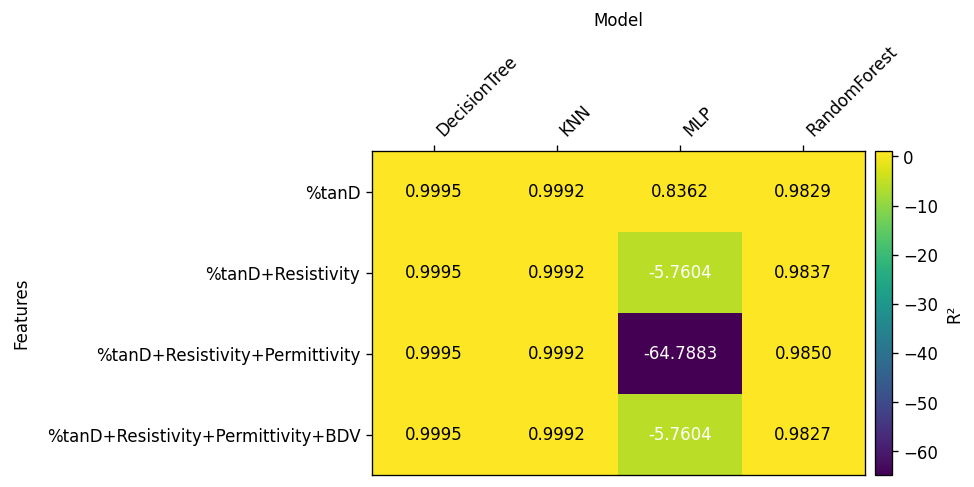

In [80]:
df_features = result_df[(result_df["fraction"]==0.2)].drop(columns=["fraction"])
df_features['features'] = df_features['features'].apply(tuple)


# df_exploded = df_features.explode('features')
# display(df_exploded)
# Pivot the table: rows as models, columns as features, and values as R2 scores
pivot_df = df_features.pivot_table(index='model', columns='features', values='R2', aggfunc='mean')

# Display the resulting table
display(pivot_df)
print(pivot_df.to_csv())
data = pivot_df.values.T
models = pivot_df.index.tolist()
features = ['+'.join(f) for f in pivot_df.columns]

fig, ax = plt.subplots(
    figsize=(8, 4),        # smaller overall figure shrinks each cell
    dpi=120                # higher DPI for crisper text/lines
)

# Draw the heatmap
cax = ax.imshow(data, cmap='viridis', aspect='auto', interpolation='nearest')
fig.colorbar(cax, label='R²', fraction=0.046, pad=0.02)

# X-axis (models) on top, angled
ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels(models, rotation=45, ha='left')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel('Model', labelpad=10)

# Y-axis (feature combos) on left
ax.set_yticks(np.arange(len(features)))
ax.set_yticklabels(features, rotation=0)
ax.set_ylabel('Features', labelpad=10)

# ax.set_title('R² Heatmap', pad=12)

# Annotate each cell
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, f'{data[i,j]:.4f}',
                ha='center', va='center',
                color='white' if data[i,j] < data.max()/2 else 'black',
                fontsize=10)

plt.tight_layout(pad=0.5)
plt.show()